In [16]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import f1_score
from sklearn.preprocessing import TargetEncoder
import sys

sys.path.insert(0, "..")
from history_based_feature_selection import test_all_features, feature_selection_history

In [17]:
pd.set_option('display.width', 32000)
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_rows', 5000)

In [18]:
# Define the model type and hyperparameters that we wish to optimize the
# set of features for. In this example, we use a decision tree.

model_dt = DecisionTreeClassifier()

# Collect the data used and divide into train and validation sets. 

In [19]:
np.random.seed(0)

data = fetch_openml('credit-g', version=1, parser='auto')
x = pd.DataFrame(data.data)
y = data.target

display(x.head())

# If y is numeric, convert to a categorical target
if pd.Series(y).astype(str).str.isnumeric().all():
    y = np.where(pd.Series(y).astype(float) > pd.Series(y).astype(float).median(), 1, 0)  

# If this is a multi-class classification problem, convert to binary classification. This makes the analysis
# simpler and allows us to use target-encoding, which is more straightforward for feature selection than one-hot.
elif pd.Series(y).astype(str).nunique() > 2:
    y = np.where(y == pd.Series(y).mode()[0], 1, 0)

# Shuffle to ensure the target classes are distributed in both the train and validation sets.
x = x.sample(n=len(x))
y = y[x.index]

# Divide into train and validate sets
n_samples = len(x) // 2
x_train = pd.DataFrame(x[:n_samples])
y_train = y[:n_samples]
x_val = pd.DataFrame(x[n_samples:])
y_val = y[n_samples:]

# Remove features that are all null
drop_cols = []
for col_name in x_train.columns:
    if x_train[col_name].count() == 0:
        drop_cols.append(col_name)
x_train = x_train.drop(columns=drop_cols)
x_val = x_val.drop(columns=drop_cols)

# Fill null values
for col_name in x_train.columns:
    if str(x_train[col_name].dtype) == 'category':
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].cat.categories[0])
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].cat.categories[0])
    elif x_train[col_name].dtype in [np.float64, np.int64]:
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].median())
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].median())
    else:
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].mode())
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].mode())

# Encode the categorical values
for col_name in x_train.columns:
    if str(x_train[col_name].dtype) in ['category', 'object']:
        encoder = TargetEncoder()
        encoder.fit(x_train[[col_name]], y_train)
        x_train[col_name] = encoder.transform(x_train[[col_name]]).flatten()
        x_val[col_name] = encoder.transform(x_val[[col_name]]).flatten()  

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


# Perform a baseline test using all features

In [20]:
test_all_features(model_dt, {}, x_train, y_train, x_val, y_val, metric=f1_score, metric_args={'average':'macro'})

# Using all features we are able to get a macro f1 score of about 0.61. This is the baseline
# we wish to beat. 

Testing with all (20) features: train score: 1.0, validation score: 0.6357243914247173


0.6357243914247173

# Test using history-based feature selection, simply searching for the highest accuracy


Generating the initial set of random candidates...
  0, [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], 0.6603988603988604
  1, [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0], 0.6268045366004624
  2, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 0.4612585001436644
  3, [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], 0.6288154182891026
  4, [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 0.6189024390243902
  5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], 0.4254397595686379
  6, [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1], 0.6343908479773559
  7, [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0], 0.5807463200189996
  8, [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], 0.5856831020261279
  9, [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], 0.606085623304635
 10, [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], 0.6223637163234479
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
100,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,-,Y,16,0.710145
97,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,Y,-,16,0.702603
203,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,-,-,Y,Y,-,14,0.701078
204,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,-,15,0.700436
171,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,-,-,14,0.699324
96,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,17,0.694589
210,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,-,Y,-,Y,15,0.693886
73,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,-,-,-,Y,Y,-,14,0.689657
65,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,-,16,0.688552
191,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,-,Y,Y,Y,-,-,Y,Y,-,14,0.688525


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


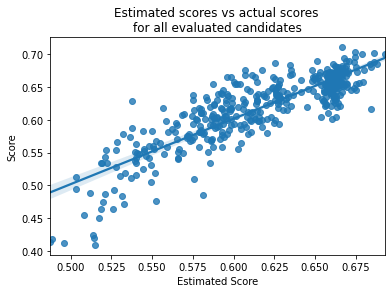

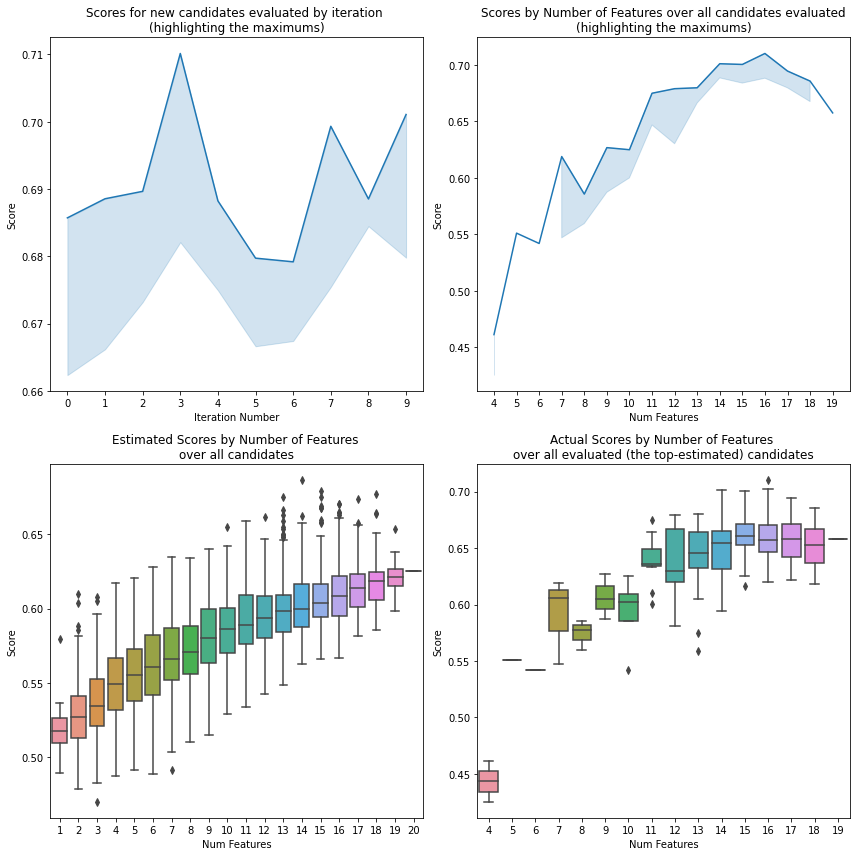

In [21]:
np.random.seed(0)

scores_df = feature_selection_history(
        model_dt, {}, 
        x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=None, penalty=None, 
        plot_evaluation=True, verbose=True, draw_plots=True, 
        metric=f1_score, metric_args={'average':'macro'})

# Here we are able to get a score of about 0.71, which beats using all features (0.64)
# This is found with a set of 15 features (the full dataset has 20).

# Test setting the maximum parameters to 5


Generating the initial set of random candidates...
  0, [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], 0.619654749182141
  1, [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0], 0.5569732411837676
  2, [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.5558672276764843
  3, [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], 0.5692990524579155
  4, [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], 0.6169230696917993
  5, [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1], 0.5350955426099167
  6, [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.5785924989464812
  7, [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0], 0.5893723131414623
  8, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 0.4117647058823529
  9, [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], 0.6523809523809524
 10, [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1], 0.5772058823529411
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
135,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,Y,5,0.676849
178,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,4,0.676849
111,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3,0.670509
188,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,3,0.667454
177,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2,0.667360
95,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,4,0.665251
88,Y,-,-,-,-,-,Y,-,-,-,Y,-,-,-,Y,-,-,-,-,Y,5,0.664445
190,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,Y,-,-,-,-,-,Y,5,0.662414
204,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,3,0.662077
212,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,-,Y,-,Y,5,0.661644


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


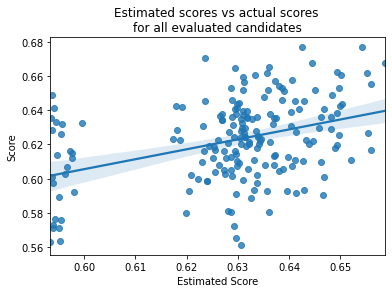

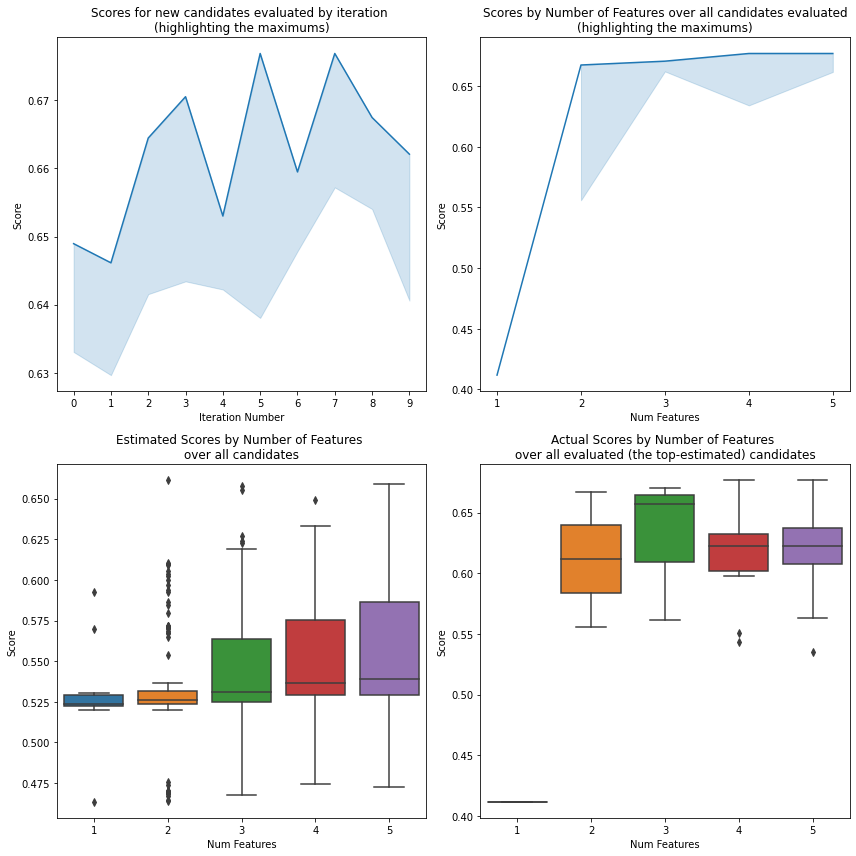

In [22]:
scores_df = feature_selection_history(
        model_dt, {}, 
        x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=5, penalty=None, 
        verbose=True, draw_plots=True, 
        metric=f1_score, metric_args={'average':'macro'})

# With only 5 features, it can't do quite as well, but still finds a set that scores about 0.68. 

# Setting the maximum features higher (to 15), but setting a penalty


Generating the initial set of random candidates...
  0, [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 0.6340364837474664
  1, [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1], 0.5837809432128391
  2, [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.5267595938736878
  3, [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1], 0.5620078507133353
  4, [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0], 0.5991103420472099
  5, [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1], 0.5982142857142857
  6, [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], 0.6288154182891026
  7, [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], 0.5315397999961758
  8, [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1], 0.5462794918330308
  9, [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], 0.6414845408133999
 10, [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], 0.6163343889950751
 1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score,Score with Penalty
28,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2,0.667360,0.637360
74,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3,0.670509,0.625509
124,Y,-,-,-,-,-,Y,-,-,-,-,Y,-,-,-,-,-,-,-,-,3,0.665825,0.620825
79,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,3,0.662077,0.617077
77,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,4,0.676849,0.616849
174,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,4,0.675542,0.615542
118,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,Y,-,-,5,0.689854,0.614854
44,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,2,0.643178,0.613178
120,Y,-,Y,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,-,-,-,3,0.657206,0.612206
175,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,3,0.656963,0.611963


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


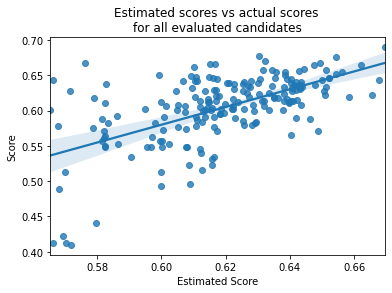

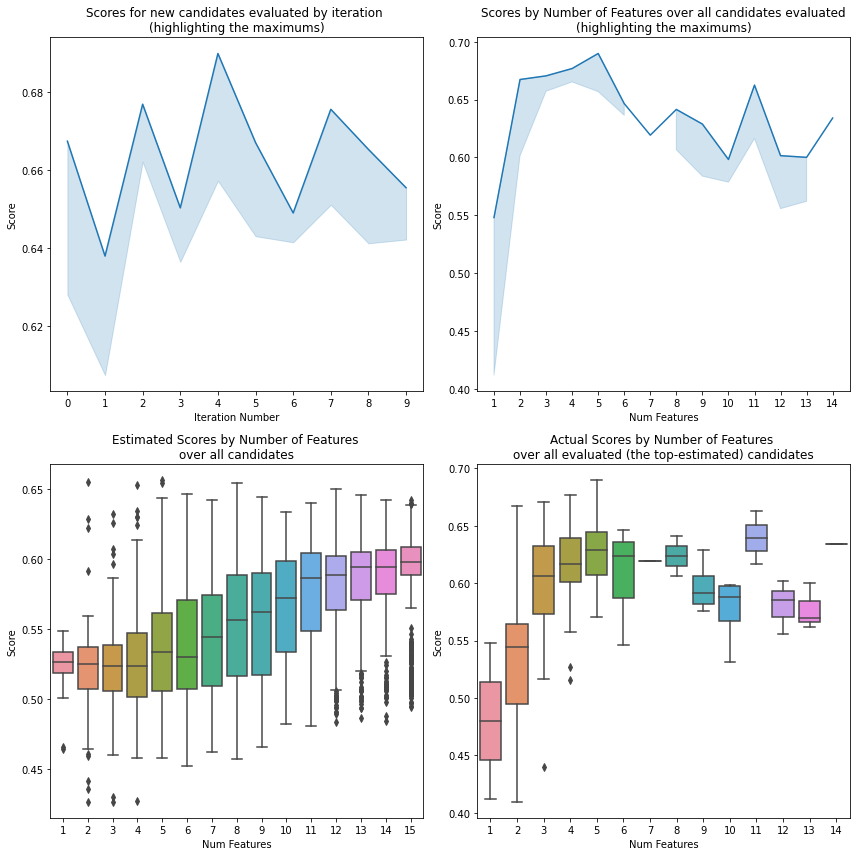

In [23]:
# This sets a penalty of 0.015, which means two feature sets are equivalent if
# one has one more feature than the other, and a score 0.01 higher. 
# For example, this would count a score of 0.80 with 10 features higher than 
# a score of 0.81 with 12 features. 

scores_df = feature_selection_history(
        model_dt, {}, 
        x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=15, penalty=0.015, 
        verbose=True, draw_plots=True, 
        metric=f1_score, metric_args={'average':'macro'})

# Setting a penalty of 0.01, it tends to return feature sets close to the maximum of 
# 15 features. Using a larger penalty of 0.015 or 0.02, it tends to select feature 
# sets with about 3 to 8 features. 

# Example continuing work seeking an optimum feature set


Generating the initial set of random candidates...
  0, [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], 0.6603988603988604
  1, [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0], 0.6268045366004624
  2, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 0.4612585001436644
  3, [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], 0.6288154182891026
  4, [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 0.6189024390243902
  5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], 0.4254397595686379
  6, [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1], 0.6343908479773559
  7, [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0], 0.5807463200189996
  8, [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], 0.5856831020261279
  9, [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], 0.606085623304635
 10, [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], 0.6223637163234479
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
65,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,-,16,0.688552
48,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,18,0.685714
27,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,Y,Y,-,-,-,Y,Y,Y,15,0.683214
71,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,Y,Y,-,Y,-,Y,Y,Y,17,0.676142
26,Y,Y,Y,Y,-,Y,-,Y,Y,-,Y,Y,Y,Y,-,Y,-,Y,Y,Y,15,0.669118
62,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,-,-,-,Y,Y,Y,16,0.668414
67,Y,Y,Y,Y,-,Y,Y,-,-,Y,-,-,Y,Y,Y,-,-,Y,Y,Y,13,0.666179
70,Y,Y,Y,Y,-,-,Y,-,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,14,0.665386
56,Y,Y,Y,Y,-,Y,-,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,15,0.665386
63,Y,Y,Y,Y,-,Y,-,-,Y,Y,Y,-,Y,Y,Y,Y,-,-,Y,Y,14,0.662696


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


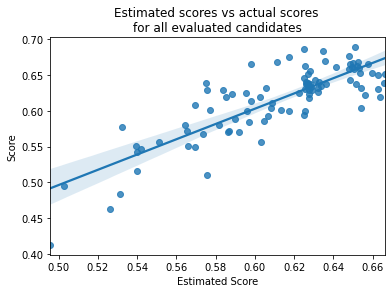

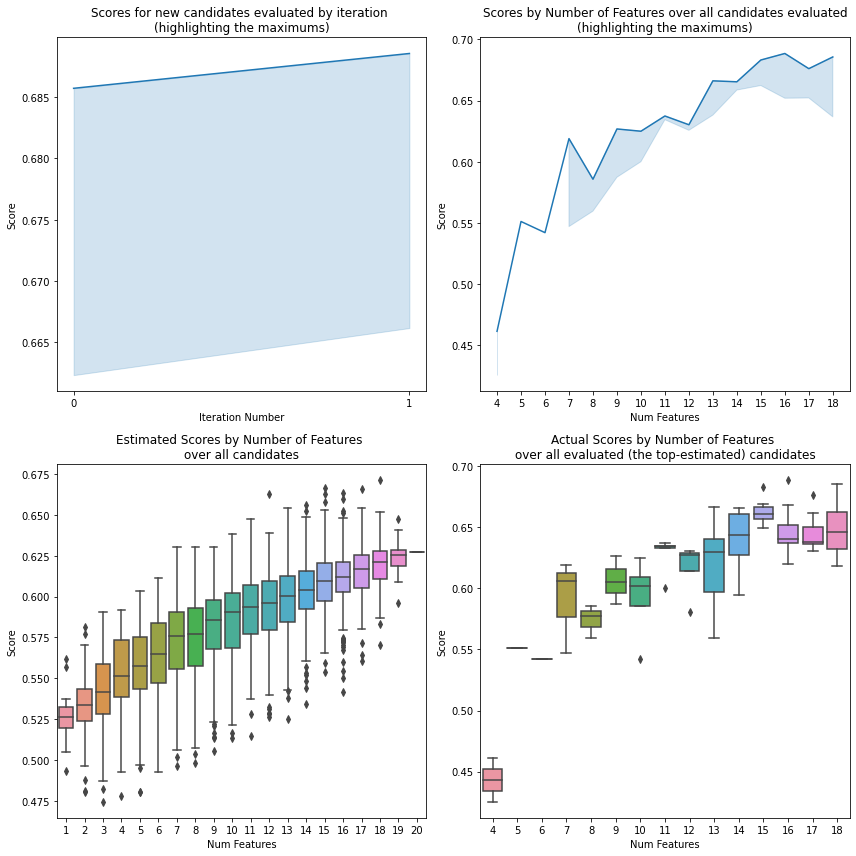

In [24]:
# In this example, we demonstrate how the feature_selection_history() method can continue
# work searching for an optimum features set, taking advantage of work done in previous 
# executions. In this cell we call feature_selection_history() as normal, specifying 
# to run for 2 iterations.

np.random.seed(0)

scores_df = feature_selection_history(
        model_dt, {}, 
        x_train, y_train, x_val, y_val,
        num_iterations=2, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=None, penalty=None, 
        verbose=True, draw_plots=True, plot_evaluation=True, 
        metric=f1_score, metric_args={'average':'macro'})


Generating the initial set of random candidates...
  0, [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0], 0.6072931276297335
  1, [0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0], 0.606085623304635
  2, [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.5340114138438881
  3, [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0], 0.6016968673218673
  4, [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], 0.5620078507133353
  5, [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 0.4117647058823529
  6, [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 0.5761904761904761
  7, [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0], 0.5939603319890439
  8, [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], 0.5907093304553416
  9, [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], 0.5967665420596218
 10, [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], 0.6033588731522328
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
184,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,Y,Y,16,0.706712
168,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,-,Y,Y,16,0.704694
228,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,-,15,0.701078
181,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,-,16,0.699722
214,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,-,Y,-,-,Y,Y,15,0.699324
206,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,Y,-,Y,Y,17,0.699275
141,Y,Y,Y,-,Y,Y,-,Y,Y,Y,-,-,Y,Y,-,Y,-,Y,-,Y,13,0.698192
144,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,-,Y,16,0.693599
105,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,-,Y,Y,16,0.693105
204,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,-,-,Y,-,Y,15,0.692531


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


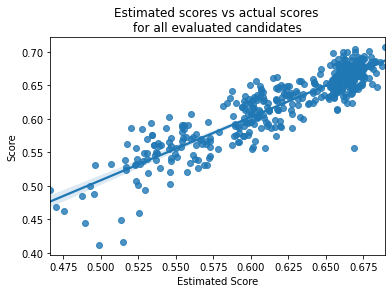

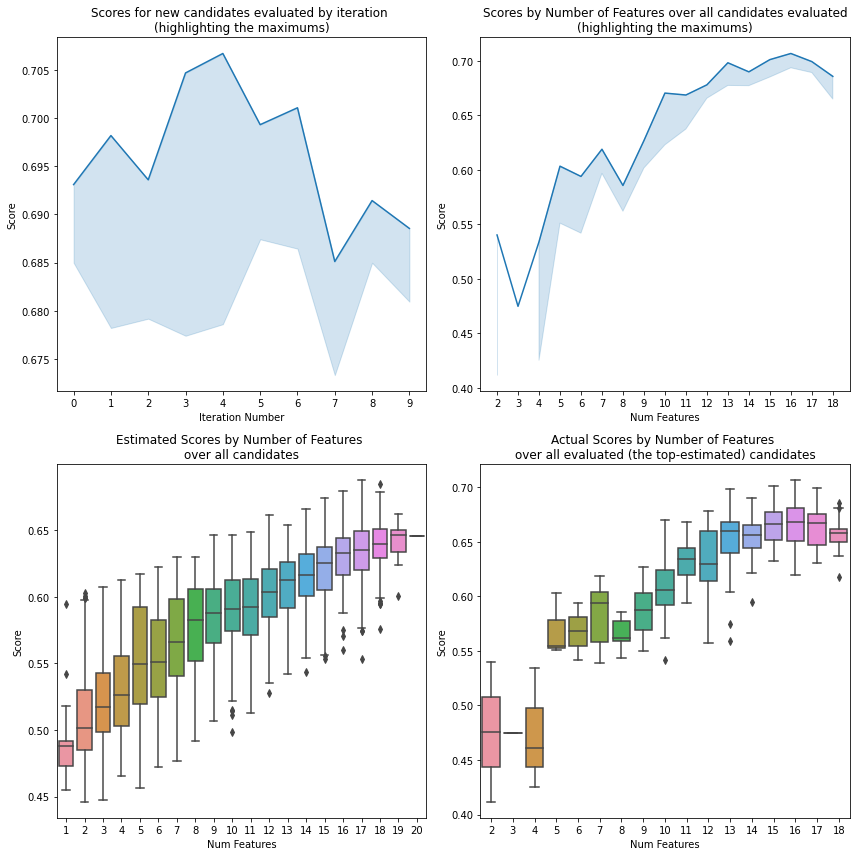

In [25]:
# In this cell, we pass scores_df (which was returned in the previous cell) in the previous_results 
# parameter, and execute for an additional 10 iterations. We can see that the scores continue to
# improve from those found in the previous execution. 

scores_df = feature_selection_history(
        model_dt, {}, 
        x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=None, penalty=None, 
        verbose=True, draw_plots=True, plot_evaluation=True, 
        metric=f1_score, metric_args={'average':'macro'},
        previous_results=scores_df)

In [26]:
# Display the full scores_df. This lists every candidate that was evaluated,
# excluding any with more than max_features features. These are ordered by the
# score with penalty if a penalty was specified. The score_with_penalty value
# is somewhat hard to interpret, but higher is better. 

scores_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
184,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,Y,Y,16,0.706712
168,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,-,Y,Y,16,0.704694
228,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,-,15,0.701078
181,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,-,16,0.699722
214,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,-,Y,-,-,Y,Y,15,0.699324
206,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,Y,-,Y,Y,17,0.699275
141,Y,Y,Y,-,Y,Y,-,Y,Y,Y,-,-,Y,Y,-,Y,-,Y,-,Y,13,0.698192
144,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,-,Y,16,0.693599
105,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,-,Y,Y,16,0.693105
204,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,-,Y,Y,Y,-,-,Y,-,Y,15,0.692531
